In [1]:
# This is a jupyter notebook that implements the behaviour of an ideal observer in the Nose Strike Paradigm

# Author: Clara Kuper
# June 2020


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import uniform
from scipy import stats
from scipy.integrate import odeint

Description: What is the ideal observer doing?

Paradigm: The observer needs to find out the position of a goal along the y axis and estimate if a moving attacker will hit the goal or not.

Strategies:
1. Center the known goal size around the currently presented stimulus and move it with each new presentation (mean).
2. Have a double-size goal and shrink it to the size of the goal (collaps).
3. Define the goal between the most excentric presented targets (expand).

Assumptions:
The ideal observer has a perfect estimate where the attacker is going to end 
The ideal observer integrates all available information 

In [2]:
# implement some general parameters like the frame of the screen etc
frame_rate = 120 # this is set by the monitor used
hz = 1/frame_rate

In [3]:
# set a table with columns: 

simulated_params = ['time', 'attacker_hit_miss',
                    'y_attacker','x_attacker','y_end_attacker', 
                    'x_target', 'y_target',
                    'goal_mean', 'goal_upper', 'goal_lower',
                    'goal_mean_est',
                    'goal_upper_mean', 'goal_lower_mean', 'decision_mean',
                    'goal_upper_collaps', 'goal_lower_collaps', 'decision_collaps',
                    'goal_upper_expand', 'goal_lower_expand', 'decision_expand']

dt = hz   # measure time steps as flips of the monitor
t  = 0.7  # let the trial run over 0.7 seconds

tar_dur = 5 # how many frames is one target shown
timesteps = int((t / dt)/tar_dur) # the time step for the simulation

# initialize the table
sim_table = pd.DataFrame(np.zeros((timesteps, len(simulated_params))),columns = simulated_params)


In [4]:
# Implement the time axis
sim_table['time'] = np.linspace(dt,t,timesteps)

In [5]:
# Implement the x and y positions of the attacker
attacker_start_x = -20 # in dva relative to center
attacker_start_y = 0

x_speed = 20/timesteps
y_speed = 0/timesteps

def move_attacker(x_pos, y_pos, x_speed, y_speed, dur):
    """
    take start point and move along two axis, return the trajectory vector
    """
    x_pos = [x_pos]
    y_pos = [y_pos]
    for update in range(1,dur):
        x_pos.append(x_pos[update-1]+x_speed)
        y_pos.append(y_pos[update-1]+y_speed)
        
    return x_pos,y_pos

x_pos, y_pos = move_attacker(attacker_start_x, attacker_start_y, 
                             x_speed, y_speed, timesteps)

sim_table['x_attacker'] = x_pos
sim_table['y_attacker'] = y_pos
sim_table['y_end_attacker'] = np.ones(timesteps)*sim_table['y_attacker'].iloc[-1]

In [6]:
# Implement the true position of the goal

goal_x = 0 # in dva relative to center
goal_y = 0 # in dva realtive to center

sim_table['goal_mean'] = np.zeros(timesteps)*goal_y

goal_height = 4 # in dva
sim_table['goal_upper'] = sim_table['goal_mean']+goal_height
sim_table['goal_lower'] = sim_table['goal_mean']-goal_height

In [7]:
# Implement the positions of the targets along the goal

def get_target_pos(goal_upper, goal_lower):
    
    tars = []
    for frame in range(0,len(goal_upper)):
        tars.append(np.random.uniform(goal_upper[frame],goal_lower[frame]))
    return tars

sim_table['y_target'] = get_target_pos(sim_table['goal_upper'], sim_table['goal_lower'])

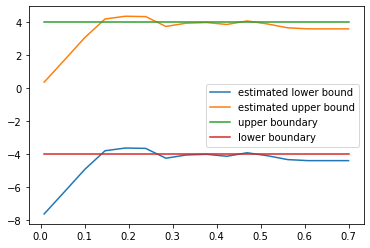

In [8]:
# Implement the mean estimate
# This estimate is based on the assumption that observers take the mean of all presented 
# targets as the assumed mean of the goal.
# it includes a "sanitiy check" that no target can be outside the mean +/- the height of
# the goal

def get_mean(x_target, height):
    mean_est = []
    for tar in range(0,len(x_target)):
        est_tar = np.mean(x_target[0:tar+1])
        search_range = [min(x_target[0:tar+1]), max(x_target[0:tar+1])]
        
        if est_tar+height < search_range[1]:
            est_tar = search_range[1] - height
            
        elif search_range[0] < est_tar-height:
            est_tar = search_range[0] + height
            
        mean_est.append(est_tar)
    upper_mean = mean_est+np.ones(len(mean_est))*height
    lower_mean = mean_est-np.ones(len(mean_est))*height
    
    return mean_est, upper_mean, lower_mean

sim_table['goal_mean_est'], sim_table['goal_upper_mean'], sim_table['goal_lower_mean'] = get_mean(sim_table['y_target'], goal_height)

fig1, ax1 = plt.subplots(1,1)
ax1.plot(sim_table['time'],sim_table['goal_lower_mean'], label = "estimated lower bound")
ax1.plot(sim_table['time'],sim_table['goal_upper_mean'], label = "estimated upper bound")
ax1.plot(sim_table['time'], sim_table['goal_upper'], label = "upper boundary")
ax1.plot(sim_table['time'], sim_table['goal_lower'], label = "lower boundary")

ax1.legend()


With this strategy, the estimate of the two boundaries converges to the "true" boundaries with the same dynamics for upper and lower bounds.
We only plot one trial here, the initially shown target could also be at a negative value, in which case the blue an red trace would be mirrowed along the "true" boundaries.

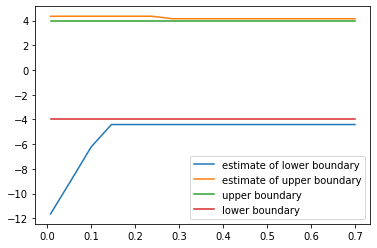

In [9]:
# Implement the upper and lower estimates (collapsing bounds)
def collaps_boundaries(x_target, height):
    
    # the mean is the mean value between the highest and the lowest value
    # the size is 2x the height of the goal and shrinks by the distance between the blocks
    
    upper = []
    lower = []
    box_init = 2*height
    
    for tar in range(0, len(x_target)):
        max_tar = max(x_target[0:tar+1])
        min_tar = min(x_target[0:tar+1])
        distance = abs(min_tar-max_tar)
        box = (box_init - distance)
        
        upper.append(max_tar+box)
        lower.append(min_tar-box)
    
    return upper, lower
        
sim_table['goal_collaps_upper'], sim_table['goal_collaps_lower'] = collaps_boundaries(sim_table['y_target'], goal_height)

fig2, ax2 = plt.subplots(1,1)
ax2.plot(sim_table['time'], sim_table['goal_collaps_lower'], label = "estimate of lower boundary")
ax2.plot(sim_table['time'], sim_table['goal_collaps_upper'], label = "estimate of upper boundary")
ax2.plot(sim_table['time'], sim_table['goal_upper'], label = "upper boundary")
ax2.plot(sim_table['time'], sim_table['goal_lower'], label = "lower boundary")
ax2.legend()

In the collapsing boundary example, the dynamics for upper and lower bound look different. One bound (the one towards which the the first presented target was biased) collapses faster against the true boundary than the opposite bound.

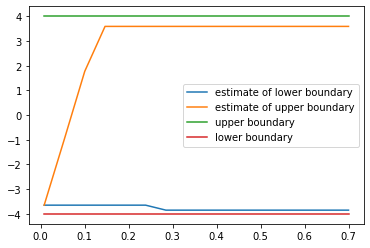

In [10]:
# Implement the upper and lower estimates (expanding boundaries)
def expand_boundaries(x_target, height):
    
    # the boundaries are always placed at the lowest and the highest presented value
    
    upper = []
    lower = []
    
    for tar in range(0, len(x_target)):
        upper.append(max(x_target[0:tar+1]))
        lower.append(min(x_target[0:tar+1]))
        
    return upper, lower

sim_table['goal_expand_upper'],sim_table['goal_expand_lower'] = expand_boundaries(sim_table['y_target'],goal_height)

fig3, ax3 = plt.subplots(1,1)
ax3.plot(sim_table['time'], sim_table['goal_expand_lower'], label = "estimate of lower boundary")
ax3.plot(sim_table['time'], sim_table['goal_expand_upper'], label = "estimate of upper boundary")
ax3.plot(sim_table['time'], sim_table['goal_upper'], label = "upper boundary")
ax3.plot(sim_table['time'], sim_table['goal_lower'], label = "lower boundary")
ax3.legend()

With expanding boundaries, we see a stronger update in the bound that tends to the opposite location of that being presented in the first few trials. 

In [11]:
# Simulate a decsion 

def make_decision(upper_est, lower_est, upper, lower, y_end):
    
    """
    takes the information from the trial and returns the response category
    """
    
    responses = []
    
    for trial in range(0, len(upper_est)):
        go = False
        hit = False
        
        if lower[trial]<y_end[trial]<upper[trial]:
            hit = True
        if lower_est[trial]<y_end[trial]<upper_est[trial]:
            go = True
        
        if go and hit:
            resp = 'hit'
        elif go and not hit:
            resp = 'false_alarm'
        elif hit and not go:
            resp = 'miss'
        else:
            resp = 'correct_reject'

        responses.append(resp)
    return responses

sim_table['decision_expand'] = make_decision(sim_table['goal_expand_upper'],sim_table['goal_expand_lower'],sim_table['goal_upper'],sim_table['goal_lower'],sim_table['y_end_attacker'])
sim_table['decision_mean'] = make_decision(sim_table['goal_upper_mean'],sim_table['goal_lower_mean'],sim_table['goal_upper'],sim_table['goal_lower'],sim_table['y_end_attacker'])
sim_table['decision_collaps'] = make_decision(sim_table['goal_collaps_upper'],sim_table['goal_collaps_lower'],sim_table['goal_upper'],sim_table['goal_lower'],sim_table['y_end_attacker'])

In [12]:
# Define an experiment with many trials and multiple attacker end points
# The goal position is not modelled, because the ideal observer won't care

simulated_params = ['trial', 'time',
                    'y_attacker', 'x_attacker', 'y_end_attacker', 
                    'x_target', 'y_target',
                    'goal_mean', 'goal_upper', 'goal_lower',
                    'p_in',
                    'goal_upper_expand', 'goal_lower_expand', 'decision_expand', 'd_prime_expand',
                    'goal_mean_est',
                    'goal_upper_mean', 'goal_lower_mean', 'decision_mean', 'd_prime_mean',
                    'goal_upper_collaps', 'goal_lower_collaps', 'decision_collaps', 'd_prime_collaps',
                   'belief_correct', 'certainty', 'forced_choice', 'CoM']

trialN = 1000
attackerY = [-5.5, -4.5, -3.5, -2.5, 2.5, 3.5, 4.5, 5.5] # all possible end points of the target relative to the goal
reps = int(trialN/len(attackerY))
goalY = 0
goal_height = 4
full_sim = []
trial = 0.0

for iteration in np.arange(reps):
    #print(table['trial'])
    #print("printed")
    #table = pd.DataFrame(np.zeros((timesteps, len(simulated_params))),columns = simulated_params)
    for end_point in attackerY:
        # time
        attacker_start_y = end_point
        table = pd.DataFrame(np.zeros((timesteps, len(simulated_params))),columns = simulated_params)
        table['time'] = np.linspace(dt,t,timesteps)
        
        # trial
        table['trial'] = np.ones(timesteps)*trial
        #print(table['trial'])
        
        # attacker
        y_speed = 0 #end_point/timesteps
        x_pos, y_pos = move_attacker(attacker_start_x, attacker_start_y, 
                             x_speed, y_speed, timesteps)

        table['x_attacker'] = x_pos
        table['y_attacker'] = y_pos
        table['y_end_attacker'] = np.ones(timesteps)*y_pos[-1]
        
        # goal
        table['goal_mean'] = np.zeros(timesteps)*goal_y
        table['goal_upper'] = table['goal_mean']+goal_height
        table['goal_lower'] = table['goal_mean']-goal_height
        
        # target
        table['y_target'] = get_target_pos(table['goal_upper'], table['goal_lower'])
        
        # estimate mean of the goal
        table['goal_mean_est'], table['goal_upper_mean'], table['goal_lower_mean'] = get_mean(table['y_target'], goal_height)
        
        # estimate for collapsing boundaries
        table['goal_upper_collaps'], table['goal_lower_collaps'] = collaps_boundaries(table['y_target'], goal_height)

        # estimate for expanding boundaries
        table['goal_upper_expand'],table['goal_lower_expand'] = expand_boundaries(table['y_target'],goal_height)

        # get decisions
        table['decision_expand'] = make_decision(table['goal_upper_expand'],table['goal_lower_expand'],table['goal_upper'],table['goal_lower'],table['y_end_attacker'])
        table['decision_mean'] = make_decision(table['goal_upper_mean'],table['goal_lower_mean'],table['goal_upper'],table['goal_lower'],table['y_end_attacker'])
        table['decision_collaps'] = make_decision(table['goal_upper_collaps'],table['goal_lower_collaps'],table['goal_upper'],table['goal_lower'],table['y_end_attacker'])
        
        # get the information if the attacker hit or missed the target:
        table['attacker_hit_miss'] = make_decision(table['goal_upper'], table['goal_lower'], table['goal_upper'], table['goal_lower'], table['y_end_attacker'])
        
        # write certainty as the known fraction of the goal
        table['certainty'] = (np.abs(table["goal_upper_expand"]-table["goal_lower_expand"]))/(2 * goal_height)
        #table['forced_choice'] = 0 if table['p_in'] < 0.5 else 1
        #table['CoM'] = np.diff(forced_choice)
        
        #new_trial = np.where(table['time'] == 0.7)[0]
        #table['CoM'].iloc[new_trial] = 0
        
        if trial == 0.0:
            simulation = table
            #print(simulation)
        else:
            simulation = pd.concat([simulation,table])
    
        trial += 1

In [13]:
simulation[10:20]

,trial,time,y_attacker,x_attacker,y_end_attacker,x_target,y_target,goal_mean,goal_upper,goal_lower,...,d_prime_mean,goal_upper_collaps,goal_lower_collaps,decision_collaps,d_prime_collaps,belief_correct,certainty,forced_choice,CoM,attacker_hit_miss
10,0.0,0.469444,-5.5,-7.50,-5.5,0.0,3.128742,0.0,4.0,-4.0,...,0.0,4.137202,-4.871258,correct_reject,0.0,0.0,0.873942,0.0,0.0,correct_reject
11,0.0,0.515556,-5.5,-6.25,-5.5,0.0,-3.942408,0.0,4.0,-4.0,...,0.0,4.057592,-4.871258,correct_reject,0.0,0.0,0.883894,0.0,0.0,correct_reject
12,0.0,0.561667,-5.5,-5.00,-5.5,0.0,1.123870,0.0,4.0,-4.0,...,0.0,4.057592,-4.871258,correct_reject,0.0,0.0,0.883894,0.0,0.0,correct_reject
13,0.0,0.607778,-5.5,-3.75,-5.5,0.0,-0.332899,0.0,4.0,-4.0,...,0.0,4.057592,-4.871258,correct_reject,0.0,0.0,0.883894,0.0,0.0,correct_reject
14,0.0,0.653889,-5.5,-2.50,-5.5,0.0,2.161864,0.0,4.0,-4.0,...,0.0,4.057592,-4.871258,correct_reject,0.0,0.0,0.883894,0.0,0.0,correct_reject
15,0.0,0.700000,-5.5,-1.25,-5.5,0.0,-0.133519,0.0,4.0,-4.0,...,0.0,4.057592,-4.871258,correct_reject,0.0,0.0,0.883894,0.0,0.0,correct_reject
0,1.0,0.008333,-4.5,-20.00,-4.5,0.0,2.254345,0.0,4.0,-4.0,...,0.0,10.254345,-5.745655,false_alarm,0.0,0.0,0.000000,0.0,0.0,correct_reject
1,1.0,0.054444,-4.5,-18.75,-4.5,0.0,-3.727852,0.0,4.0,-4.0,...,0.0,4.272148,-5.745655,false_alarm,0.0,0.0,0.747775,0.0,0.0,correct_reject
2,1.0,0.100556,-4.5,-17.50,-4.5,0.0,3.715096,0.0,4.0,-4.0,...,0.0,4.272148,-4.284904,correct_reject,0.0,0.0,0.930368,0.0,0.0,correct_reject
3,1.0,0.146667,-4.5,-16.25,-4.5,0.0,3.262839,0.0,4.0,-4.0,...,0.0,4.272148,-4.284904,correct_reject,0.0,0.0,0.930368,0.0,0.0,correct_reject


In [14]:
# check for evenness in the attacker/goal distribution
np.unique(simulation["y_end_attacker"])

array([-5.5, -4.5, -3.5, -2.5,  2.5,  3.5,  4.5,  5.5])

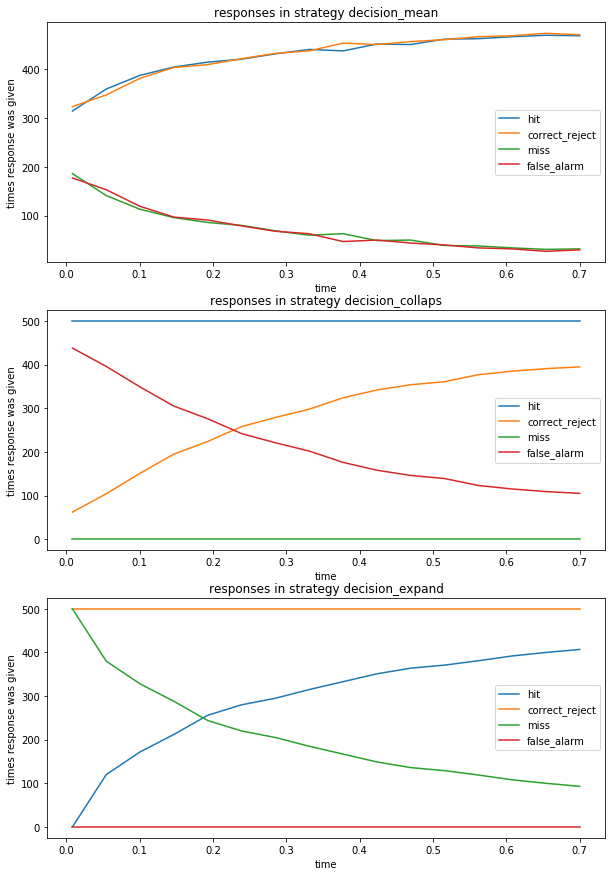

In [15]:
# plot the probability of each decision type over time
# create the statistics of each response type over time 

times = simulation['time'].unique()
responses = ['hit', 'miss', 'correct_reject', 'false_alarm']
cols = ['time', 'hit', 'miss', 'correct_reject', 'false_alarm']

# different strategies
strategies = ['decision_mean', 'decision_collaps', 'decision_expand']
fig4, ax4 = plt.subplots(len(strategies),1, figsize = (10,15))
plotID = 0

for strategy in strategies:
# get a list of the unique time steps
    proportion_answers = pd.DataFrame(np.zeros((len(times), len(cols))),columns = cols)
    proportion_answers['time'] = times
    for response in responses:
        resps = []
        for time in times:
            sub_table = simulation[strategy].iloc[np.where(simulation['time'] == time)]
            resps.append(len(np.where(sub_table==response)[0]))
        proportion_answers[response] = resps

    ax4[plotID].plot(proportion_answers['time'],proportion_answers['hit'], label = 'hit')
    ax4[plotID].plot(proportion_answers['time'],proportion_answers['correct_reject'], label = 'correct_reject')
    ax4[plotID].plot(proportion_answers['time'],proportion_answers['miss'], label = 'miss')
    ax4[plotID].plot(proportion_answers['time'],proportion_answers['false_alarm'], label = 'false_alarm')
    ax4[plotID].set_title('responses in strategy {}'.format(strategy))
    ax4[plotID].set_xlabel('time')
    ax4[plotID].set_ylabel('times response was given')
    ax4[plotID].legend() 
    
    plotID += 1

Simulating responses for the three strategies shows the following patterns:

In a mean estimate, the correct rejection and hit rate converge to the total number of trials, while false responses and misses go down. A correct decision is at any point in time more likely than an incorrect decison. There is no difference between the curve for correct rejections and hits.

In the collapsing bounds example, the system never misses a trial, but makes many false alarms. That value drops while at the same time, the correct rejection rate rises.

The opposite pattern shows in the expanding boundary version: There are nor false alarms, but may misses at the beginning. The rate of misses drops and the rate of hits increases.

In [16]:
# d' ratings of the mean, collapsing and expanding strategies
# compute d' curve time - d_prime
# evaluate which strategy performs best at which time, and if there is a difference at all

# how to compute d' 
def get_d_prime(hit, miss, fa, cr):
    
    # there must be at least one instance of each response type
    if hit == 0:
        hit = 1
    if miss == 0:
        miss = 1
    
    if fa == 0:
        fa = 1
    if cr == 0:
        cr =1
    
    # Floors an ceilings are replaced by half hits and half FA's
    #half_hit = 0.5 / (hit + miss)
    #half_fa = 0.5 / (fa + cr)
    
    # compute rates
    hit_rate = hit/(hit+miss)
    fa_rate = fa/(fa+cr)
    
    # check for ceilings
#     if fa_rate == 1: 
#         fa_rate = 1 - half_fa
#     if fa_rate == 0: 
#         fa_rate = half_fa
        
#     if hit_rate == 1: 
#         hit_rate = 1 - half_hit
#     if hit_rate == 0: 
#         hit_rate = half_hit
        
    
    return stats.norm.ppf(hit_rate)- stats.norm.ppf(fa_rate)

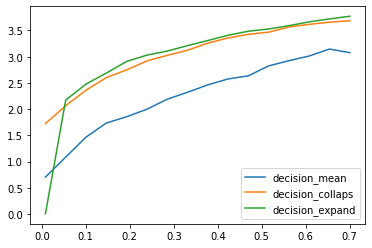

In [17]:
# compute d' for each observer strategy:

# set up:
# your pool of strategies
# defined above

# your loop for the pool

# your data frame (np.array) for output 

d_primes = np.zeros((2, len(times), len(strategies)))

for stra_id, stra in enumerate(strategies):
    # which data do i want to look at?
    # start a new frame
    for t_id, t in enumerate(times):
            sub_table = simulation[stra].iloc[np.where(simulation['time'] == t)]
                        
            hits = len(np.where(sub_table=="hit")[0])
            misses = len(np.where(sub_table=="miss")[0])
            fas = len(np.where(sub_table=="false_alarm")[0])
            crs = len(np.where(sub_table=="correct_reject")[0])
            
            d_prime = get_d_prime(hits, misses, fas, crs)
            
            d_primes[0,t_id,stra_id] = t
            d_primes[1,t_id,stra_id] = d_prime

fig5, ax5 = plt.subplots(1)

ax5.plot(times,d_primes[1,:,0], label=strategies[0])
ax5.plot(times,d_primes[1,:,1], label=strategies[1])
ax5.plot(times,d_primes[1,:,2], label=strategies[2])

ax5.legend()

Conclusion: The strategy in which the observer tries to approximate the location of the goal from the mean location of all previously presented targets is the most effective strategy. 
The least effective strategy is assuming a double - sized goal around the mean of the presented stimuli and collapsing the boundaries.


---- could this be bc the position of the attacker relative to the 

### Simulating reaction times of the ideal observer

Step 1: Compute probability of one point x being within the borders of the goal

Step 2: Build a drift diffusion model for the decisions

Step 3: Build a drift rate + sensory delay + motor delay, with the decision made in the moment of 90% confidence

Step 4: Build a model in which the race starts with a drift rate adjusted by the evidence before the race starts + sensory delay + motor delay

Step 4: Two models:  a) Drift rate set once when certainty is high enough or time is running out b) Drift rate is flexibly adjusted when new information comes in

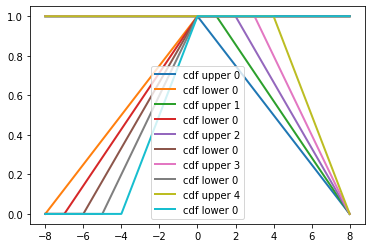

In [18]:
# simulate the probability of the target being around the known borders

fig6, ax6 = plt.subplots(1, 1)

upper = [0, 1, 2, 3, 4]
lower = [0,0,0,0,0]
width = 4
hit = -3.2

full_range = np.linspace(-2*width, 2*width, 1000)

for t in range(0, len(lower)):
    
    free_width = 2* width - np.abs(lower[t]-upper[t])
   # print(free_width)
       
    if free_width == 0:
        free_width = 10**-100
        
    #full_space = np.linspace(lower[t]-free_width,upper[t]+free_width, 1000)

    up_cdf = 1 - uniform.cdf(full_range, loc = upper[t], scale = free_width)
    low_cdf = uniform.cdf(full_range, loc = lower[t]-free_width, scale = free_width)
    
    ax6.plot(full_range, up_cdf,
             lw=2, label='cdf upper {}'.format(upper[t]))
    ax6.plot(full_range, low_cdf,
             lw=2, label='cdf lower {}'.format(lower[t]))
    ax6.legend()
    
    abs_dist = np.min(abs(full_range - hit))
    hit_pos = np.where(abs(full_range-hit) == abs_dist)
    
   # print(hit_pos)
   # print(min(up_cdf[hit_pos][0], low_cdf[hit_pos][0]))

In [19]:
# The probability of a point is a uniform distribution of the point with in the remaining unknown width
# The probability of a point being within the borders is the cumulative probability density up to that point.

def get_inbound(lower, upper, width, hit):
    
    out_vec = []
    # define the space where the attacker could potentially land
    full_range = np.linspace(-2*width, 2*width, 1000)
    #fig7,ax7 = plt.subplots(1, 1)
    p_in = 0
    for t in range(0,len(hit)):
        p_old = p_in
        # calculate how much of that space is not yet observed, 
        # the observed space is the distance between the lowest point shown and the highest point shown
        free_width = 2*width - np.abs(lower.iloc[t]-upper.iloc[t])
        
        # it is not allowed to have a too steep incline here, so if the full goal has been revealed, we set the width to a small number
        if free_width == 0:
            free_width = 10**-100
        
        # the span over which our function should increase
        # full_space = np.linspace(lower.iloc[t]-free_width, upper.iloc[t]+free_width, 1000)
        
        # the probability at the upper bound. 
        # uniform.cdf takes the following arguments:
        # full_space = the range of the function
        # loc = the point when the cdf starts increasing, 
        # scale = how quickly the cdf increases 
        # since we invert the function by computing 1-cdf, loc = the point when the cdf reaches probability 1
        # this is the point at which the upper bound was shown
        upper_cdf = 1 - uniform.cdf(full_range, loc = upper.iloc[t], scale = free_width)
        # the probability at the lower bound
        # we don't invert the function, so we need to set loc to the actual point when the function starts increasing, 
        # which is the lowest shown point - the free width
        lower_cdf = uniform.cdf(full_range, loc = lower.iloc[t]-free_width, scale = free_width)
        
        hit_pos = np.argmin(abs(full_range - hit.iloc[t]))
        #hit_pos = np.where(abs(full_range-hit.iloc[t]) == abs_dist)
        
        #ax7.plot(full_range, upper_cdf)
        #ax7.plot(full_range, lower_cdf)
        p_in = min(upper_cdf[hit_pos], lower_cdf[hit_pos])
            
        out_vec.append(p_in)
        
    return out_vec

In [20]:
# Compute the reaction time of an observer, who makes a decision, when he/she is 90% certain

# Get presented data
# Compute certainty
# Get time point of decision
# Add sensory and motor delay

# the probability of the target being inside the goal
simulation['p_in'] = get_inbound(simulation['goal_lower_expand'], simulation['goal_upper_expand'], goal_height, simulation['y_end_attacker'])
go_dec = np.where(simulation['p_in'] > 0.5)
no_go_dec = np.where(simulation['p_in']<=0.5)
# the most likely response at every single time 
simulation['forced_choice'].iloc[go_dec] = 0 
simulation['forced_choice'].iloc[no_go_dec] = 1
# a change of mind from go -> no_go = -1
# a change of mind from no_go -> go = 1
simulation['CoM'].iloc[1:] = np.diff(simulation['forced_choice'])
new_trial = np.where(simulation['time'] == 0)[0]
simulation['CoM'].iloc[new_trial] = 0

# here, we need to look at the probability of the attacker being OUTSIDE the goal
out_box = np.where(simulation['attacker_hit_miss'] == 'correct_reject')

# define the estimated probability of the correct response
simulation['belief_correct'] = simulation['p_in']
simulation['belief_correct'].iloc[out_box] = 1-simulation['belief_correct'].iloc[out_box]

# mean of certainty against time
def belief_correct_time(times, belief_correct):
    
    col_names = ['time', 'mean_belief_correct', 'sd_belief_correct']
    out_table = pd.DataFrame(np.zeros((len(np.unique(times)), len(col_names))),columns = col_names)
    
    for row, time in enumerate(np.unique(times)):
        row_idx = np.where(times == time)
        belief_correct_mean = np.mean(belief_correct.iloc[row_idx])
        belief_correct_sd = np.std(belief_correct.iloc[row_idx])
        
        out_table['time'].iloc[row] = time
        out_table['mean_belief_correct'].iloc[row] = belief_correct_mean
        out_table['sd_belief_correct'].iloc[row] = belief_correct_sd
        
    return out_table
    


C:\Users\ClaraQ\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


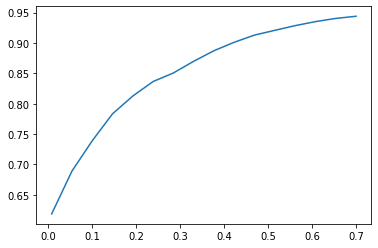

In [21]:
belief_correct_frame = belief_correct_time(simulation['time'], simulation['belief_correct'])
plt.plot(belief_correct_frame['time'],belief_correct_frame['mean_belief_correct'])

In [22]:
# save the simulated trials in a table

save_sim = simulation.iloc[:,0:15]
save_sim.to_csv('sim1000.csv', sep=',')

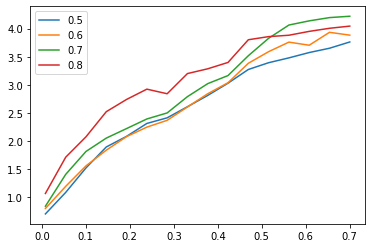

In [23]:
# d' values for a response at a given certainty

thresholds = [0.5, 0.6, 0.7, 0.8]

d_primes_belief_correct = np.zeros((2, len(times), len(thresholds)))

for thr_id, thresh in enumerate(thresholds):
    for t_id, t in enumerate(times):
        # this needs to go for every single trial
            sub_table = simulation.iloc[np.where(simulation['time'] == t)]
            
            gos = np.where(sub_table["p_in"] > thresh)
            no_gos = np.where(sub_table["p_in"] <= thresh)
            attacker_hits = np.where(sub_table['attacker_hit_miss']=='hit')
            attacker_miss =np.where(sub_table['attacker_hit_miss']=='correct_reject')
            
            hits = len(np.intersect1d(gos, attacker_hits))
            misses = len(np.intersect1d(no_gos, attacker_hits))
            fas = len(np.intersect1d(gos,attacker_miss))
            crs = len(np.intersect1d(no_gos, attacker_miss))
            
            #print(hits, misses, fas, crs)
            
            d_prime = get_d_prime(hits, misses, fas, crs)
            #print(d_prime)
            
            d_primes_belief_correct[0,t_id,thr_id] = t
            d_primes_belief_correct[1,t_id,thr_id] = d_prime
                      
fig7, axs7 = plt.subplots(1)
for id_thr, thresh in enumerate(thresholds):
                      
    axs7.plot(times, d_primes_belief_correct[1,:,id_thr], label=thresh)
    
axs7.legend()

In [24]:
# get a reaction time distribution
trials = np.unique(simulation["trial"])
#print(trials)
thresholds = [0.6, 0.7, 0.8, 0.9]
ncols = len(thresholds)+1
nrows = len(trials)
resp_table = np.zeros((nrows,ncols))

for thresh_id, thresh in enumerate(thresholds):
    for trial_id, trial in enumerate(trials):
        
        ids = np.where(simulation["trial"]== trial)
        trial_data = simulation.iloc[ids[0]]
        above_threshold = np.where(trial_data["belief_correct"] > thresh)
        thresholded_data = trial_data.iloc[above_threshold[0]]
        try:
            #take the lowest certainty value above threshold
            #rea_t_id = np.argmin(thresholded_data["certainty"])
            #rea_t = thresholded_data["time"].iloc[rea_t_id]
            #take the first time when the threshold was crossed
            rea_t_id = np.argmin(thresholded_data["time"])
            rea_t = thresholded_data["time"].iloc[rea_t_id]
            resp = 1 if thresholded_data["attacker_hit_miss"].iloc[rea_t_id] == 'hit' else 0
            
        except ValueError:
            #rea_t_id = np.argmax(trial_data["certainty"])
            #rea_t = trial_data["time"].iloc[rea_t_id]
            rea_t_id = np.argmax(trial_data["time"])
            rea_t = trial_data["time"].iloc[rea_t_id]
            resp = 0 if trial_data["attacker_hit_miss"].iloc[rea_t_id] ==  'hit' else 0
        
        resp_table[trial_id, thresh_id] = rea_t
        resp_table[trial_id, ncols-1] = resp
        
#print(resp_table)


In [25]:
print("The mean time after which 60% belief in correct answer are reached is {} ms".format(int(np.mean(resp_table[:,0])*1000)))
print("The mean time after which 70% belief in correct answer are reached is {} ms".format(int(np.mean(resp_table[:,1])*1000)))
print("The mean time after which 80% belief in correct answer are reached is {} ms".format(int(np.mean(resp_table[:,2])*1000)))
print("The mean time after which 90% belief in correct answer are reached is {} ms".format(int(np.mean(resp_table[:,3])*1000)))

The mean time after which 60% belief in correct answer are reached is 91 ms
The mean time after which 70% belief in correct answer are reached is 127 ms
The mean time after which 80% belief in correct answer are reached is 175 ms
The mean time after which 90% belief in correct answer are reached is 232 ms


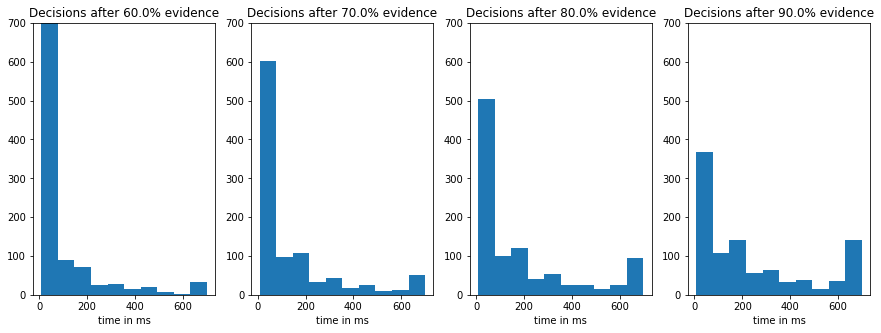

In [26]:
# plot histograms

fig8, axs8 = plt.subplots(1,4, figsize = (15,5))

for ids, evidence in enumerate(thresholds):
    axs8[ids].hist(resp_table[:,ids]*1000, bins = 10)
    axs8[ids].set_title("Decisions after {}% evidence".format(evidence*100))
    axs8[ids].set_xlabel("time in ms")
    axs8[ids].set_ylim(0,700)

In [27]:
# get a reaction time distribution for certainty (defined as knowledge about true goal position)
trials = np.unique(simulation["trial"])
#print(trials)
thresholds = [0.2, 0.4, 0.6, 0.8]
ncols = len(thresholds)+1
nrows = len(trials)
certainty_table = np.zeros((nrows,ncols))

for thresh_id, thresh in enumerate(thresholds):
    for trial_id, trial in enumerate(trials):
        
        ids = np.where(simulation["trial"]== trial)
        trial_data = simulation.iloc[ids[0]]
        above_threshold = np.where(trial_data["certainty"] > thresh)
        thresholded_data = trial_data.iloc[above_threshold[0]]
        try:
            #take the lowest certainty value above threshold
            #rea_t_id = np.argmin(thresholded_data["certainty"])
            #rea_t = thresholded_data["time"].iloc[rea_t_id]
            #take the first time when the threshold was crossed
            rea_t_id = np.argmin(thresholded_data["time"])
            rea_t = thresholded_data["time"].iloc[rea_t_id]
            resp = 1 if thresholded_data["attacker_hit_miss"].iloc[rea_t_id] == 'hit' else 0
            
        except ValueError:
            #rea_t_id = np.argmax(trial_data["certainty"])
            #rea_t = trial_data["time"].iloc[rea_t_id]
            rea_t_id = np.argmax(trial_data["time"])
            rea_t = trial_data["time"].iloc[rea_t_id]
            resp = 0 if trial_data["attacker_hit_miss"].iloc[rea_t_id] ==  'hit' else 0
        
        certainty_table[trial_id, thresh_id] = rea_t
        certainty_table[trial_id, ncols-1] = resp

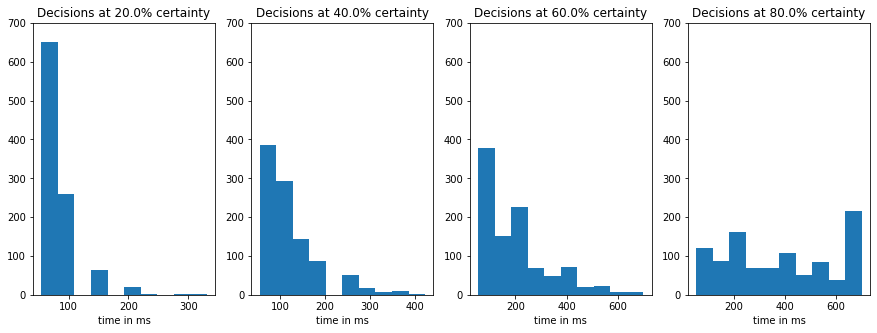

In [28]:
# plot histograms

fig9, axs9 = plt.subplots(1,4, figsize = (15,5))

for ids, certainty in enumerate(thresholds):
    axs9[ids].hist(certainty_table[:,ids]*1000, bins = 10)
    axs9[ids].set_title("Decisions at {}% certainty".format(certainty*100))
    axs9[ids].set_xlabel("time in ms")
    axs9[ids].set_ylim(0,700)

(array([ 15.,  18.,  75., 139., 391., 875., 582., 356., 215., 155., 140.,
        101.,  69.,  38.,  14.]),
 array([-0.54259655, -0.44594022, -0.34928388, -0.25262755, -0.15597122,
        -0.05931489,  0.03734144,  0.13399777,  0.2306541 ,  0.32731043,
         0.42396676,  0.5206231 ,  0.61727943,  0.71393576,  0.81059209,
         0.90724842]),
 <a list of 15 Patch objects>)

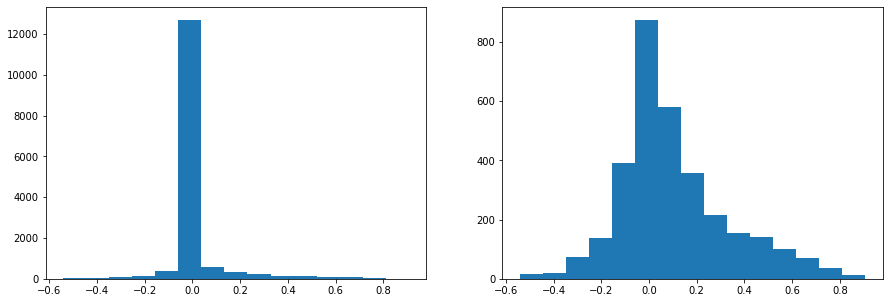

In [29]:
# update value instead of certainty
update_value = np.diff(simulation["belief_correct"])
# mask the transition from one trial to the next
in_trial = np.where(simulation["time"]<0.7)

update_value = update_value[in_trial[0]]

fig10, axs10 = plt.subplots(1,2 , figsize = (15,5))
axs10[0].hist(update_value, bins = 15)

# since we can see that there are many 0-updates, we mask these entries to get a better picture of the remaining distribution

non_zero_vals = np.where(update_value != 0)
masked_values = update_value[non_zero_vals[0]]

axs10[1].hist(masked_values, bins = 15)

In [30]:
# update_value = np.diff(simulation["p_in"])
# # mask the transition from one trial to the next
# in_trial = np.where(simulation["time"]<0.7)

# update_value = update_value[in_trial[0]]

# fig10, axs10 = plt.subplots(1 , figsize = (15,5))
# #axs10[0].hist(update_value, bins = 15)

# # since we can see that there are many 0-updates, we mask these entries to get a better picture of the remaining distribution

# non_zero_vals = np.where(update_value != 0)
# masked_values = update_value[non_zero_vals[0]]

# axs10.hist(masked_values, bins = 15)

In [31]:
# in how many trials did a CoM occur?
trials = np.unique(simulation['trial'])
trial_count_CoM = np.zeros((2,len(trials)))
trial_count_CoM[0,:] = trials
for trial in trials:
    trial_count_CoM[1,int(trial)] = np.sum(abs(simulation['CoM'].iloc[np.where(simulation['trial']==trial)]))

[[  0.   1.   2. ... 997. 998. 999.]
 [  0.   2.   1. ...   2.   5.   4.]]


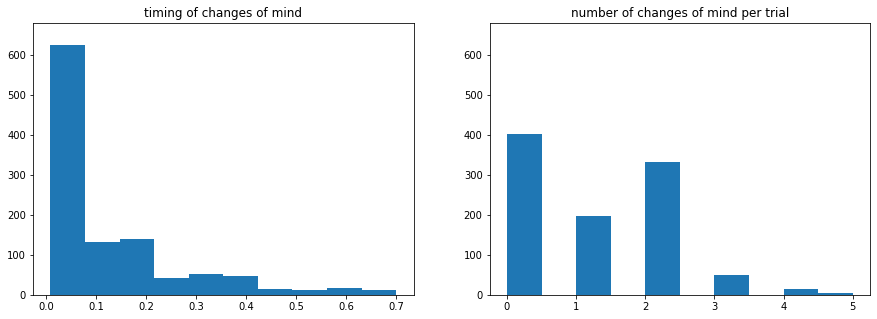

In [32]:
# What was the time when a CoM occured?
CoM_only = np.where(simulation['CoM']!=0)[0]

time_CoM = simulation['time'].iloc[CoM_only]

fig11, axs11 = plt.subplots(1,2, figsize = (15,5))

axs11[0].hist(time_CoM)
axs11[0].set_title('timing of changes of mind')
axs11[0].set_ylim(0,680)
axs11[1].hist(trial_count_CoM[1,:])
axs11[1].set_ylim(0,680)
axs11[1].set_title('number of changes of mind per trial')

print(trial_count_CoM)

In [33]:
print('In {}% of trials, at least one change of mind occured'.format(len(np.where(trial_count_CoM[1,:]>0)[0])/10))

In 59.8% of trials, at least one change of mind occured


(array([5118.,  607.,  786.,  668.,  788.,  764.,  737.,  657.,  673.,
        5202.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

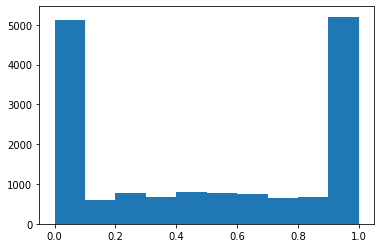

In [34]:
plt.hist(simulation['p_in'])

In [35]:
np.unique(simulation['p_in'])

array([0.00000000e+00, 3.20596515e-04, 7.44340210e-04, ...,
       9.99487273e-01, 9.99979240e-01, 1.00000000e+00])